In [1]:
# ==============================================================================
# Imports
# ==============================================================================

# This is needed so that python finds the utils
import sys
sys.path.append("/home/gf332/miracle-compession/code")
sys.path.append("/home/gf332/miracle-compession/code/compression")
sys.path.append("/Users/gergelyflamich/Documents/Work/MLMI/miracle-compession/code")
sys.path.append("/Users/gergelyflamich/Documents/Work/MLMI/miracle-compession/code/compression")

import matplotlib.pyplot as plt
import numpy as np

from imageio import imwrite

import argparse
import os, glob
import json
from tqdm import tqdm_notebook as tqdm

# Needed for compression as the common source of randomness
from sobol_seq import i4_sobol_generate
from scipy.stats import norm, truncnorm

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tf.enable_eager_execution()

from architectures import ClicCNN, ClicHyperVAECNN, ClicLadderCNN, ClicLadderCNN2
from experiment import clic_input_fn
from utils import is_valid_file, setup_eager_checkpoints_and_restore
from load_data import load_and_process_image, create_random_crops, download_process_and_load_data

from sampling import IntervalTree, a_star_sample, a_star_sample_codable, normal_normal_log_diff, normal_normal_region_bound

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
# ==============================================================================
# Predefined Stuff
# ==============================================================================

models = {
    "cnn": ClicCNN,
    "hyper_cnn": ClicHyperVAECNN,
    "ladder_cnn": ClicLadderCNN,
    "ladder_cnn2": ClicLadderCNN2
}


optimizers = {
    "sgd": tf.train.GradientDescentOptimizer,
    "momentum": lambda lr:
                    tf.train.MomentumOptimizer(learning_rate=lr,
                                               momentum=0.9,
                                               use_nesterov=False),
    "adam": tf.train.AdamOptimizer,
    "rmsprop": tf.train.RMSPropOptimizer
}

In [3]:
!ls /home/gf332/miracle-models

hyper_cnn_gauss_gauss_prior	 ladder_cnn_gauss_gauss_prior
hyper_cnn_laplace		 ladder_cnn_laplace_gauss_prior
ladder_cnn2_laplace_gauss_prior


In [4]:
model_key="ladder_cnn2"
model_dir="/home/gf332/miracle-models/ladder_cnn2_laplace_gauss_prior/"
config_path=None
is_training=False

# ==========================================================================
# Configuration
# ==========================================================================

config = {
        "training_set_size": 93085,
        "pixels_per_training_image": 256 * 256 * 3,
        
        # When using VALID for the hierarchical VAEs, this will give the correct
        # latent size
        "image_size": [256, 256],

        "batch_size": 8,
        "num_epochs": 20,
        
        "first_level_channels": 192,
        "second_level_channels": 128,
        "first_level_layers": 4,

        "loss": "nll_perceptual_kl",
        "likelihood": "laplace",
        "prior": "gaussian",
        
        # % of the number of batches when the coefficient is capped out 
        # (i.e. for 1., the coef caps after the first epoch exactly)
        "warmup": 2., 
        "beta": 0.1,
        "gamma": 0.,
        "learning_rate": 3e-5,
        "optimizer": "adam",

        "log_freq": 50,
        "checkpoint_name": "_ckpt",
    }

if config_path is not None:
    config = json.load(config_path)

# ==========================================================================
# Create VAE model
# ==========================================================================

with tf.device("CPU:0"):
    model = models[model_key]

    if model_key == "cnn":
        vae = model(prior=config["prior"],
                    likelihood=config["likelihood"],
                    padding="SAME_MIRRORED")
        
    elif model_key in ["hyper_cnn", "ladder_cnn", "ladder_cnn2"]:
        vae = model(latent_dist=config["prior"],
                    likelihood=config["likelihood"],
                    first_level_channels=config["first_level_channels"],
                    second_level_channels=config["second_level_channels"],
                    first_level_layers=config["first_level_layers"],
                    padding_first_level="SAME_MIRRORED",
                    padding_second_level="SAME_MIRRORED")

    # Connect the model computational graph by executing a forward-pass
    vae(tf.zeros((1, 256, 256, 3)))

    optimizer = optimizers[config["optimizer"]](config["learning_rate"])

    # ==========================================================================
    # Define Checkpoints
    # ==========================================================================

    global_step = tf.train.get_or_create_global_step()

    trainable_vars = vae.get_all_variables() + (global_step,)
    checkpoint_dir = os.path.join(model_dir, "checkpoints")

    checkpoint, ckpt_prefix = setup_eager_checkpoints_and_restore(
        variables=trainable_vars,
        checkpoint_dir=checkpoint_dir,
        checkpoint_name=config["checkpoint_name"])

Instructions for updating:
Colocations handled automatically by placer.
Checkpoint found at /home/gf332/miracle-models/ladder_cnn2_laplace_gauss_prior/checkpoints/_ckpt-6, restoring...
Model restored!


In [5]:
train_image_dir = "/home/gf332/.keras/datasets/miracle_image_compression/train/"
valid_image_dir = "/home/gf332/.keras/datasets/miracle_image_compression/valid"

train_image_paths = glob.glob(train_image_dir + "/*.png")
valid_image_paths = glob.glob(valid_image_dir + "/*.png")

johns_image = "/home/gf332/miracle-compession/img/poster/new_court.jpeg"
thong_vo_image = '/home/gf332/.keras/datasets/miracle_image_compression/valid/thong-vo-428.png'

with tf.device("CPU:0"):
    
    train_img_1 = load_and_process_image(thong_vo_image)
    encoded_1 = vae(tf.convert_to_tensor(train_img_1[None, ...]))
    
    encoded_1 = tf.clip_by_value(encoded_1, 0., 1.)
    ms_ssim = tf.image.ssim_multiscale(tf.convert_to_tensor(train_img_1), encoded_1, 1.)
    psnr = tf.image.psnr(tf.convert_to_tensor(train_img_1), encoded_1, max_val=1.0).numpy()[0]
    
    print("MS-SSIM: {:.4f}".format(ms_ssim.numpy()[0]))
    print("PSNR: {:.4f}".format(psnr))
    
    print("KL divergence (log2): {:.2f}".format(vae.kl_divergence.numpy() / np.log(2)))
    print("Last KL (log2): {:.2f}".format(tf.reduce_sum(tfd.kl_divergence(vae._latent_posteriors[0], vae._latent_priors[0]))  / np.log(2)))

MS-SSIM: 0.8577
PSNR: 22.7167
KL divergence (log2): 160463.20
Last KL (log2): 159122.89


In [36]:
train_img_1 = load_and_process_image(thong_vo_image)
train_img_1.shape

TensorShape([Dimension(790), Dimension(1264), Dimension(3)])

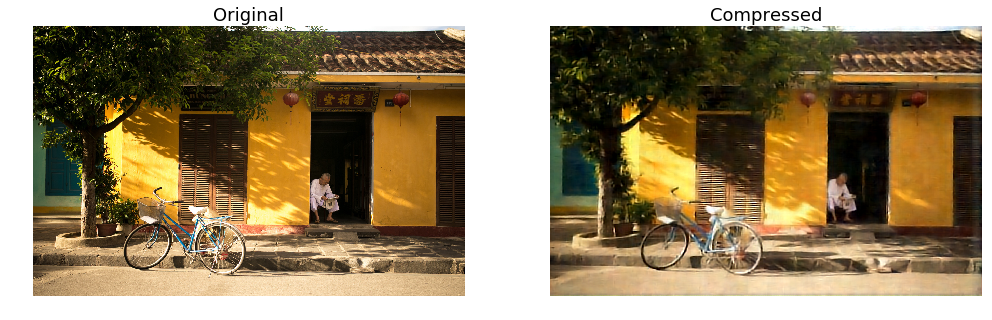

In [6]:
plt.figure(figsize=(17, 8))
plt.subplot(121)
plt.imshow(train_img_1)
plt.title("Original", fontsize=18)
plt.axis("off")

plt.subplot(122)
plt.title("Compressed", fontsize=18)
plt.imshow(tf.squeeze(encoded_1).numpy())
plt.axis("off")

plt.show()

In [34]:
from imageio import imwrite

clipped = np.squeeze(encoded_1.numpy())
clipped[clipped > 1] = 1
clipped[clipped < 0] = 0

clipped *= 255

clipped = clipped.astype(np.uint8)

im_path = "/home/gf332/miracle-compession/img/poster/thong_vo_uncompressed.png"

if not os.path.exists(im_path):
    imwrite(im_path, clipped)
else:
    print("{} already exists".format(im_path))

# Get results on the whole CLIC validation dataset

In [12]:
valid_image_dir = "/home/gf332/.keras/datasets/miracle_image_compression/valid"
valid_image_paths = glob.glob(valid_image_dir + "/*.png")

results = []

with tf.device("CPU:0"):
    for im_path in tqdm(valid_image_paths):

        image = tf.convert_to_tensor(load_and_process_image(valid_image_paths[0]))[None, ...]

        reconstruction = vae(image)
        reconstruction = tf.clip_by_value(reconstruction, 0., 1.)

        ms_ssim = tf.image.ssim_multiscale(tf.convert_to_tensor(image), reconstruction, 1.).numpy()[0]
        psnr = tf.image.psnr(image, reconstruction, max_val=1.0).numpy()[0]

        results.append((im_path, ms_ssim, psnr))

In [26]:
paths, ssims, psnrs = zip(*results)

ssim_mean = np.mean(ssims)
ssim_std = np.std(ssims)

psnrs_mean = np.mean(psnrs)
psnrs_std = np.std(psnrs)

print("MS-SSIM: {:.4f} \pm {:.4f}".format(ssim_mean, ssim_std))
print("PSNR: {:.2f} \pm {:.4f}".format(psnrs_mean, psnrs_std))

MS-SSIM: 0.9667 \pm 0.0001
PSNR: 32.49 \pm 0.0054


# Actual compression bit

In [17]:
def coded_sample(prior_loc, prior_scale, post_loc, post_scale, samp_tree, seed, use_codable=False):
    
    # Define functions to be used during the sampling procedure
    prop_trunc_samp = lambda a, b: truncnorm.ppf(np.random.uniform(), a, b)
    
    prop_log_mass = lambda a, b: np.log(norm.cdf(b, loc=prior_loc, scale=prior_scale) - \
                                        norm.cdf(a, loc=prior_loc, scale=prior_scale))
    
    log_diff = lambda x: normal_normal_log_diff(x, prior_loc, prior_scale, post_loc, post_scale)
    
    region_bound = lambda a, b: normal_normal_region_bound(a, 
                                                           b, 
                                                           prior_loc, 
                                                           prior_scale, 
                                                           post_loc, 
                                                           post_scale)
    
    prop_cdf = lambda x: norm.cdf(x, loc=prior_loc, scale=prior_scale)
    prop_inv_cdf = lambda x: norm.ppf(x, loc=prior_loc, scale=prior_scale)
    
    
    
    # Draw the sample
    if use_codable:
        return a_star_sample_codable(prop_log_mass=prop_log_mass, 
                                     log_diff=log_diff, 
                                     samp_tree=samp_tree,
                                     prop_cdf=prop_cdf,
                                     prop_inv_cdf=prop_inv_cdf,
                                     region_bound=region_bound,
                                     eps=1e-2)
    else:
        return a_star_sample(prop_trunc_samp=prop_trunc_samp, 
                              prop_log_mass=prop_log_mass, 
                              log_diff=log_diff, 
                              region_bound=region_bound, 
                              seed=seed, 
                              code_path=None)

In [12]:
valid_image_dir = "/home/gf332/.keras/datasets/miracle_image_compression/valid"
valid_image_paths = glob.glob(valid_image_dir + "/*.png")

with tf.device("CPU:0"):
    
    train_img_1 = load_and_process_image(valid_image_paths[0])
    res = vae.encode(tf.convert_to_tensor(train_img_1[None, ...]))
    
    res = vae.decode(res, decode_level=2)

In [10]:
# Define constants
num_samples = 2**15

# Get all the stuff we will need to work with

# Prior sufficient statistics
p_mu_2 = vae._latent_priors[1].mean().numpy().flatten()
p_sigma_2 = vae._latent_priors[1].stddev().numpy().flatten()
p_mu_1 = vae._latent_priors[0].mean().numpy().flatten()
p_sigma_1 = vae._latent_priors[0].stddev().numpy().flatten()

# Posterior sufficient statistics
q_mu_2 = vae._latent_posteriors[1].mean().numpy().flatten()
q_sigma_2 = vae._latent_posteriors[1].stddev().numpy().flatten()
q_mu_1 = vae._latent_posteriors[0].mean().numpy().flatten()
q_sigma_1 = vae._latent_posteriors[0].stddev().numpy().flatten()

shape_2 = p_mu_2.shape
shape_1 = p_mu_1.shape

samp_tree = IntervalTree(num_nodes=num_samples)

samp_tree.depth

16

In [17]:
p_sigma_2[q_sigma_2 > p_sigma_2]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       8.41856003e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       6.66569918e-04, 0.00000000e+00, 0.00000000e+00, 3.71918827e-03,
       0.00000000e+00, 0.00000000e+00, 4.04422358e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.24169141e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [11]:
correction_counter = 0

for i in tqdm(range(len(p_mu_2))):
    if np.abs(q_sigma_2[i] - p_sigma_2[i]) < 0.1:
        q_sigma_2[i] += 0.1 if q_sigma_2[i] > p_sigma_2[i] else -0.1
        
        correction_counter += 1
        
print("Corrected: {}".format(correction_counter))


Corrected: 23529


In [12]:
correction_counter = 0

for i in tqdm(range(len(p_mu_1))):
    if np.abs(q_sigma_1[i] - p_sigma_1[i]) < 0.1:
        q_sigma_1[i] += 0.1 if q_sigma_1[i] > p_sigma_1[i] else -0.1
        
        correction_counter += 1
        
print("Corrected: {}".format(correction_counter))

Corrected: 2012000


In [20]:
import time

bad_latents = []
samples = []

np.random.seed(5)

for i in tqdm(range(len(p_mu_2))):
    
    if np.abs(p_mu_2[i] - q_mu_2[i]) / p_sigma_2[i] > 3.:
        bad_latents.append(i)
    else:
        start = time.time()
        samp = coded_sample(p_mu_2[i], p_sigma_2[i], q_mu_2[i], q_sigma_2[i], samp_tree, i, use_codable=False)
        total_time = time.time() - start
        if total_time > 0.5:
            print("idx {}, samp idx {}, time {:.4f}".format(i, samp[2], total_time))
        samples.append(samp)

In [54]:
# v bad indices
# 79233
# 1213
# 33547
# 33291

np.random.seed(40)

i = 33547

#coded_sample(p_mu_2[i], p_sigma_2[i], q_mu_2[i], q_sigma_2[i], samp_tree)

In [55]:
print(p_mu_2[i], p_sigma_2[i], q_mu_2[i], q_sigma_2[i])

0.0 1.0 -1.564332 0.07892555


In [19]:
import time

bad_latents = []
samples = []

np.random.seed(5)

for i in tqdm(range(len(p_mu_1))):
    
    if np.abs(p_mu_1[i] - q_mu_1[i]) / p_sigma_1[i] > 3.:
        bad_latents.append(i)
    else:
        start = time.time()
        samp = coded_sample(p_mu_1[i], p_sigma_1[i], q_mu_1[i], q_sigma_1[i], samp_tree, i, use_codable=False)
        total_time = time.time() - start
        if total_time > 0.5:
            print("idx {}, samp idx {}, time {:.4f}".format(i, samp[2], total_time))
        samples.append(samp)

FloatingPointError: divide by zero encountered in log

In [21]:
search_length = [len(x[2]) for x in samples]
plt.hist(search)

14

In [22]:
count = 0

for i in range(len(p_mu_1)):
    
    count += 1 if p_sigma_1[i] > q_sigma_1[i] else 0
    
print(count)

1378887


In [15]:
np.percentile(tf.reshape(
    tf.abs(vae._latent_posteriors[0].mean() - vae._latent_priors[0].mean()) / vae._latent_priors[0].stddev(), 
    [-1]).numpy(), 99.99)

2.9221276718377727

In [16]:
np.percentile(tf.abs(vae._latent_posteriors[0].stddev() - vae._latent_priors[0].stddev()).numpy(), 100)

5.084369659423828

In [17]:
tf.reshape(vae._latent_priors[0].stddev(), [-1])[8355]

<tf.Tensor: id=4044, shape=(), dtype=float32, numpy=1.4254277>

In [22]:
bad = vae._latent_posteriors[0].stddev().numpy()[(vae._latent_posteriors[0].mean() > 3).numpy()]


In [23]:
np.prod(vae._latent_posteriors[0].mean().shape.as_list())

2113536

In [24]:
len(bad)

8428

In [25]:
kls = tfd.kl_divergence(vae._latent_posteriors[0], vae._latent_priors[0])

In [27]:
np.percentile(kls.numpy()[(vae._latent_posteriors[0].mean() > 2.5213994548321015).numpy()], 50)

0.7081917822360992

In [35]:
kls = tfd.kl_divergence(vae._latent_posteriors[1], vae._latent_priors[1])

In [28]:
np.max(kls)

20.35207

In [33]:
np.save("p_mu.npy", p_mu_2)
np.save("p_sigma.npy", p_sigma_2)
np.save("q_mu.npy", q_mu_2)
np.save("q_sigma.npy", q_sigma_2)

In [48]:
np.random.seed()